# COGS 108 - EDA Checkpoint

# Names

- Jennifer Jiang
- Hannah Ordonez
- Daniela Garcia 
- Ghada Barhoush
- Stephanie Li
- Cynthia Delira


<a id='research_question'></a>
# Research Question

> *How might the experiences of women and men differ in tech in terms of mental health issues/comfortability of discussing mental health issues?*

# Setup

In [1]:
import pandas as pd
import numpy as np
import os
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# tech_data_fp = os.path.join('data', 'survey.csv')
tech_data = pd.read_csv('data/survey.csv')

# Data Cleaning

In [3]:
#Dropping Columns that are not necessary for analysis

tech_data = tech_data.drop(columns = ['Timestamp', 'state','wellness_program',\
                                      'seek_help', 'anonymity', 'phys_health_consequence',\
                                      'coworkers', 'supervisor', 'mental_health_interview',\
                                      'phys_health_interview', 'mental_vs_physical', 'comments'])





In [4]:
#Renaming Columns for Ease of Understanding
tech_data.columns = ['Age', 'Gender', 'Country', 'Self Employed',\
                     'Family History', 'Sought Treatment', 'Work Interfere',\
                    'Number Employees', 'Work Remotely', 'Tech Company',\
                    'Offer Benefits', 'Knowledge of Care Options', 'How Easy to take Medical Leave',\
                    'Mental Health Consequences', 'Observed Consequences']








In [5]:
#Remove upper and lower .05% of Ages to filter out outliers
lower = tech_data['Age'].quantile(.005)

upper = tech_data['Age'].quantile(.995)

tech_data = tech_data[(tech_data['Age']>=lower) & (tech_data['Age']<=upper)]

In [6]:
#Taking care of most gender inputs
gender_expression = lambda x: re.sub(r'^Male|^male|^.* Male|^.* male|M |^m$| M', 'M', x)
gender_expression2 = lambda x: re.sub(r'Female|female|^f$|Woman|Female[.]*|cis-female/femme|Female (trans)|Female (cis)|woman|Femake|Cis Female|Trans-female|queer/she/they| F|F ', 'F', x)

tech_data['Gender'] =(tech_data['Gender'].apply(gender_expression)).apply(gender_expression2)

In [7]:
for_replacement = ['M', 'M', 'M', 'M',\
                   'M', 'NB', 'M', 'NB',\
                   'NB', 'NB', 'NB', 'F',\
                   'M', 'NB', 'NB', 'M', \
                   'M', 'M', 'M', 'M',\
                   'M', 'F', 'M', 'M',\
                   'NB', 'F', 'NB', 'F',\
                   'M', 'F', 'F', 'M',\
                   'M', 'F', 'M', 'M',\
                   'M']
    

In [8]:
#takes care of the rest of the gender inputs
counter = 0
for i in tech_data[(tech_data['Gender']!= 'M') & (tech_data['Gender']!='F')]['Gender'].index:
    tech_data['Gender'].loc[i] = for_replacement[counter]
    counter +=1

/var/folders/7g/5dngg9xn7pxb7j2xdsxfbldr0000gp/T/ipykernel_46703/3636781357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_data['Gender'].loc[i] = for_replacement[counter]


In [9]:
#one-hot encoding of strictly yes/no columns for ease of computation
tech_data[['Self Employed', 'Family History', 'Sought Treatment',\
           'Work Remotely', 'Tech Company', 'Observed Consequences']] \
= tech_data[['Self Employed', 'Family History', 'Sought Treatment', \
             'Work Remotely', 'Tech Company', 'Observed Consequences']]\
.replace('Yes', 1).replace('No', 0)




In [10]:
# Ordering columns for ease of interpretation
ordered_columns = ['Age', 'Gender', 'Country', 'Number Employees',\
                   'Work Interfere', 'Offer Benefits', 'Knowledge of Care Options',\
                  'How Easy to take Medical Leave', 'Mental Health Consequences',\
                  'Self Employed', 'Family History', 'Sought Treatment', 'Work Remotely', 'Tech Company',\
                  'Observed Consequences']

tech_data = tech_data[ordered_columns]

In [11]:
tech_data = tech_data.reset_index().drop(columns = 'index')

In [12]:
tech_data = tech_data[tech_data['Tech Company']!=0]

In [13]:
tech_data = tech_data.drop(columns = 'Tech Company')

In [14]:
tech_data['Work Interfere'].unique()

array(['Often', 'Rarely', 'Never', 'Sometimes', nan], dtype=object)

In [15]:
def ord_encoder_interfere(string):
    if string == 'Often':
        return 4
    elif string == 'Sometimes':
        return 3
    elif string=='Rarely':
        return 2
    elif string == 'Never':
        return 1

In [16]:
def ord_encoder_consequence(string):
    if string == 'No':
        return -1
    elif string == 'Maybe':
        return 0
    elif string == 'Yes':
        return 1

In [17]:
tech_data['Work Interfere Ordinal'] = tech_data['Work Interfere'].apply(ord_encoder_interfere)

In [18]:
tech_data['Mental Health Consequences Ordinal'] = tech_data['Mental Health Consequences'].apply(ord_encoder_consequence)

# Data Analysis & Results (EDA)

## Comparing Levels of Mental Health Work Interference and Gender

This section focuses on comparing the survey participants' responses to the question: "If you have a mental health condition, do you feel that it interferes with your work?" 

The column ```'Work Interfere Ordinal'``` in the ```tech_data``` dataframe maps each level of perceived mental health work interference to a specific ordinal number: 'Never' to 1.0, 'Rarely' to 2.0, 'Sometimes' to 3.0, and 'Often' to 4.0. 

We analyze the data in a few different methods, first looking at counting numbers of male, female, and nonbinary employees' levels of mental health work interference, then comparing the proportion of each level of mental health work interference reported by different genders, and finally comparing the average reported level of mental health work interference by gender.

There are no outliers present in our data because for the work interference question, the participants were given predefined answer choices to choose from, thus maintaining consistency in their answers. However, we noted that amongst the participants, there are a significantly higher number of male (637) participants in comparison to female (163) and non-binary participants (8). 

In [19]:
work_interference = tech_data[['Gender', 'Work Interfere Ordinal']]
work_interference = work_interference.dropna(subset = ['Work Interfere Ordinal'])
work_interference = work_interference.reset_index(drop = True)

In [20]:
# df of all gender and non-null work interference survey responses
# used for Fig. 1 visualization
work_interference

,Gender,Work Interfere Ordinal
0,F,4.0
1,M,2.0
2,M,4.0
3,M,1.0
4,M,3.0
...,...,...
803,M,3.0
804,M,4.0
805,M,3.0
806,M,4.0


In [21]:
prop_work_int = work_interference[['Gender', 'Work Interfere Ordinal']].value_counts().reset_index(name='Proportion')
prop_work_int = prop_work_int.sort_values(by = ['Gender', 'Work Interfere Ordinal'])
prop_work_int = prop_work_int.reset_index(drop = True)

def count_total(start_idx, end_idx):
    total = 0
    for i in range(start_idx, end_idx):
        total += prop_work_int.at[i, 'Proportion']
    return total

total_f = count_total(0, 4)
total_m = count_total(4, 8)
total_nb = count_total(8, 11)

def set_prop(start_idx, end_idx, total):
    for i in range(start_idx, end_idx):
        prop_work_int.at[i, 'Proportion'] /= total

set_prop(0, 4, total_f)
set_prop(4, 8, total_m)
set_prop(8, 11, total_nb)

In [22]:
# df of proportions of gender against mental health work interference
prop_work_int

,Gender,Work Interfere Ordinal,Proportion
0,F,1.0,0.104294
1,F,2.0,0.220859
2,F,3.0,0.527607
3,F,4.0,0.147239
4,M,1.0,0.248038
5,M,2.0,0.156986
6,M,3.0,0.461538
7,M,4.0,0.133438
8,NB,1.0,0.125000
9,NB,2.0,0.125000


In [23]:
data1 = [['F', 0.104294, 0.220859, 0.527607, 0.147239],
        ['M', 0.248038, 0.156986, 0.461538, 0.133438],
        ['NB', 0.125000, 0.125000, 0.750000, 0.000000]]
prop_work_int2 = pd.DataFrame(data1, columns=['Gender', '1.0', '2.0', '3.0', '4.0'])

In [24]:
# df reorganizing proportions of gender against mental health work interference
# used for Fig. 2 data visualization
prop_work_int2

,Gender,1.0,2.0,3.0,4.0
0,F,0.104294,0.220859,0.527607,0.147239
1,M,0.248038,0.156986,0.461538,0.133438
2,NB,0.125000,0.125000,0.750000,0.000000


In [26]:
def average(start_idx, end_idx):
    sum_whatever = 0
    total_gender = 0
    for i in range(start_idx, end_idx):
        total_gender += prop_work_int.at[i, 'Proportion']
        sum_whatever += prop_work_int.at[i, 'Work Interfere Ordinal'] * prop_work_int.at[i, 'Proportion']
    return sum_whatever/total_gender

average_f = average(0, 4)
average_m = average(4, 8)
average_nb = average(9, 11)

In [27]:
data2 = [['F', average_f], ['M', average_m], ['NB', average_nb]]
average_work_int = pd.DataFrame(data2, columns=['Gender', 'Average Work Interference Ordinal'])

In [28]:
# df comparing gender and average level of mental health work interference
# used for Fig. 3 data visualization
average_work_int

,Gender,Average Work Interference Ordinal
0,F,2.717791
1,M,2.480377
2,NB,2.857143


### Figure 1

This bar graph compares numbers of female, male, and non-binary employees by levels of mental health work interference.

<AxesSubplot:xlabel='Work Interfere Ordinal', ylabel='count'>

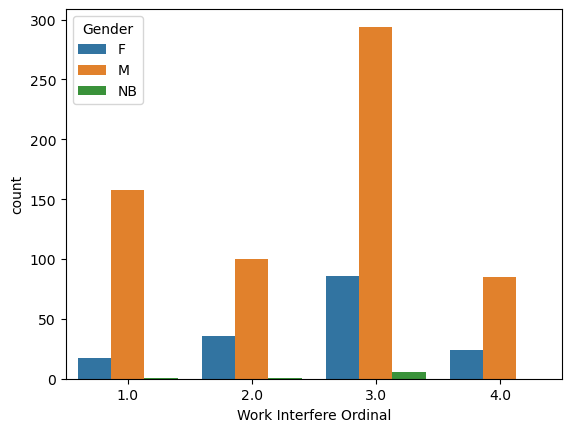

In [29]:
sns.countplot(data = work_interference, x = "Work Interfere Ordinal", hue = "Gender")

### Figure 2

This stacked bar plot compares proportions of perceived level of mental health and work interference among female, male, and non-binary employees.

<function matplotlib.pyplot.show(close=None, block=None)>

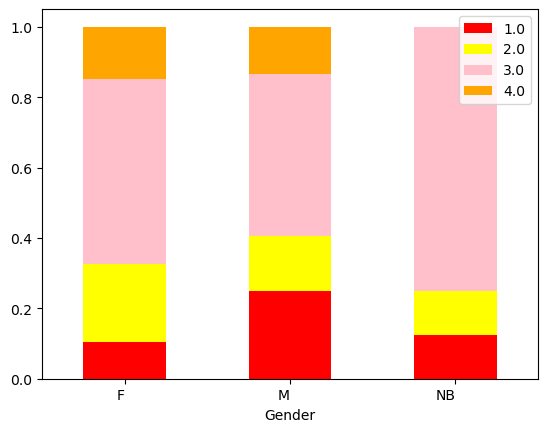

In [30]:
plot = prop_work_int2.set_index('Gender').plot(kind='bar', stacked=True, color=['red','yellow', 'pink', 'orange'])
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, ha="right")
plt.show

### Figure 3

This barplot compares averages of perceived mental health work interference among female, male, and non-binary employees.

<AxesSubplot:xlabel='Gender', ylabel='Average Work Interference Ordinal'>

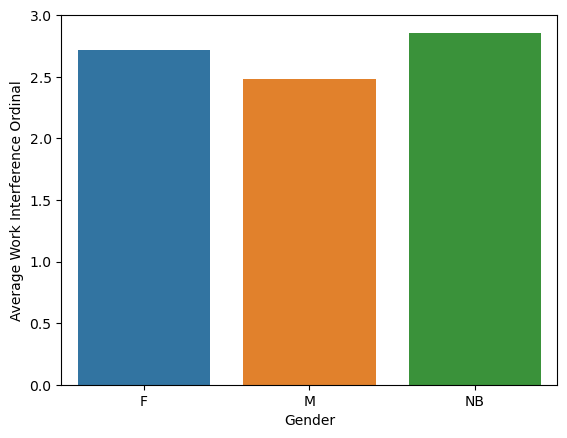

In [31]:
sns.barplot(data = average_work_int, x='Gender', y='Average Work Interference Ordinal')

For Figure 1, we created a bar plot that shows the number of responses for each level of perceived mental health work interference by gender group. This led to a bar plot that was not particularly helpful in determining if there was any correlation between gender and mental health work interference, as the large number of male participants caused the number of female and non binary participant responses to appear insignificant.

With this significant difference in male, female, and nonbinary participants in mind, we decided to look at the proportions of each response by gender. We created a stacked bar plot to visualize the proportions of each level of perceived mental health work interference response among each gender group (Figure 2). Based on this plot, we noticed that a greater proportion of male respondents never felt any sense of work interference from their mental health, as shown by the greater block of red (1.0) shown in Figure 2. Both female and non-binary respondents commonly felt that their mental health interfered with their work, represented by the orange (4.0, often) and pink (3.0, sometimes) blocks.

We also wanted to know, on average, if women reported higher mental health work interference than men. We used a bar plot to visualize the average level of perceived mental health work interference for each gender group (Figure 3). Based on this plot, we noticed that female and non-binary identifying individuals reported slightly higher mental health work interference on average than male employees.

## Comparing Employees' Levels of Comfort Discussing Mental Health and Gender


This section focuses on the survey question, "Do you think that discussing a mental health issue with your employer would have negative consequences?" This is an important question regarding the research that we are analyzing. Our research question asks whether or not there is a difference between how comfortable women feel in terms of discussing their mental health issues with their employers as compared to men. As part of our hypothesis and background research, we believe that women would have more trouble opening up about these issues due to their fear of not being taken seriously, or being judged as they can be already undermined due to their gender. We will look through the data in this section while comparing the variables of "Mental Heath Consequences" with values of -1 for 'No', 0 for 'Maybe and 1 for 'Yes'. "Gender" has values of M for Male, F for Female, and NB for non-binary. 

Here we look at the columns that consist of the variables we are focusing on: 

In [32]:
gender_consequence = tech_data[['Mental Health Consequences Ordinal', 'Gender']]
# Extracting only the Ordinal Mental Health Consequences and Gender Columns 
gender_consequence

,Mental Health Consequences Ordinal,Gender
0,-1,F
2,-1,M
3,1,M
4,-1,M
5,-1,M
...,...,...
1240,1,M
1242,-1,M
1243,-1,M
1244,1,M


The next code looks at the means of each gendered group: 

In [33]:
#Group means of Mental Health Consequences Ordinal
grouped_gender = gender_consequence.groupby('Gender').mean().sort_values(by = 'Mental Health Consequences Ordinal', ascending = False)
grouped_gender

,Mental Health Consequences Ordinal
Gender,
NB,0.250000
F,-0.057592
M,-0.240291


Here we have a bar plot to observe the results of the mean responses from the gendered groups. 

<AxesSubplot:xlabel='Gender', ylabel='Mental Health Consequences Ordinal'>

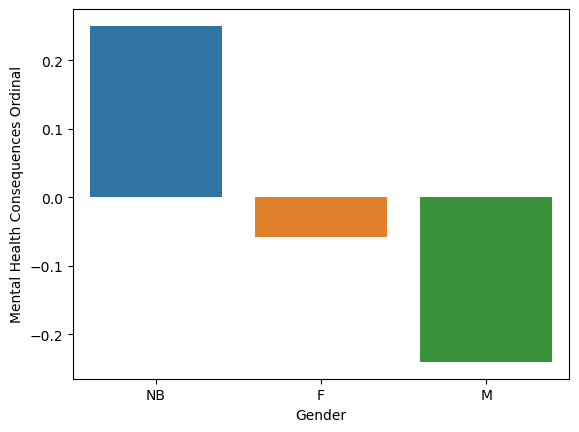

In [34]:
#shows the difference in mean values between the three gender identities
sns.barplot(data = grouped_gender.reset_index(), x = 'Gender', y = 'Mental Health Consequences Ordinal')

See above that Non-Binary identifying employees have the highest average, followed by Female-identifying. remember that -1 is no, don't feel like their employers will fault discussions about mental health and 1 is yes, feel like there are consequences to discussions regarding mental health. we see that F and NB are closer to 1 than M employees, meaning that there's a discrepancy between gender identity but we'll investigate that further.This could further validate our hypothesis when it comes to the differentiation of comfortability between the genders when discussing mental health with employers. 

## Now, we are comparing non-males and males (One group of F and NB, other group is M)

Here we have the mean of responses from males. 

In [35]:
# Mean of mental health consequences value for males
m_mean = gender_consequence[gender_consequence.Gender=='M']['Mental Health Consequences Ordinal'].mean()
m_mean

-0.24029126213592233

Here we have the mean of responses from non-males. 

In [36]:
#Mean of mental health consequences value for non-males
nonm_mean = gender_consequence[gender_consequence.Gender!='M']['Mental Health Consequences Ordinal'].mean()
nonm_mean

-0.04522613065326633

The difference of mean of males - mean of non-males

In [37]:
#Difference of the means (Male vs. Non-Male)
obs = nonm_mean - m_mean

In [38]:
obs

0.195065131482656

## Now, we are looking at the means visually with histograms. 

Histogram of the mean responses from female employees. Remember -1 is "No", 0 is "Maybe" and 1 is "Yes" to the answer of being comfortable discussing mental health issues with employers without facing consequences. 

<AxesSubplot:xlabel='Mental Health Consequences Ordinal', ylabel='Count'>

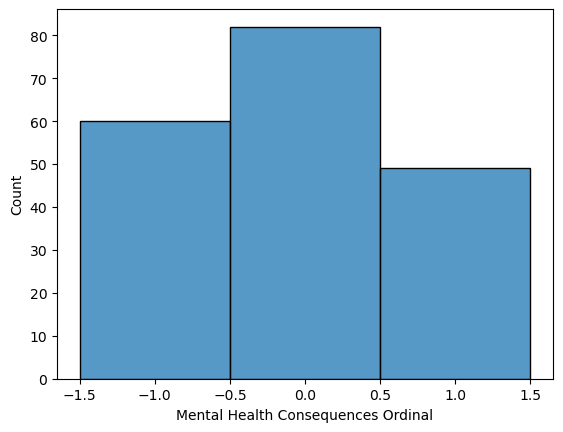

In [39]:
#histograms of ordinal mental health consequences for females
sns.histplot(gender_consequence[gender_consequence.Gender=='F'], x = 'Mental Health Consequences Ordinal', discrete = True)


Histogram of the mean responses from non-binary employees. 

<AxesSubplot:xlabel='Mental Health Consequences Ordinal', ylabel='Count'>

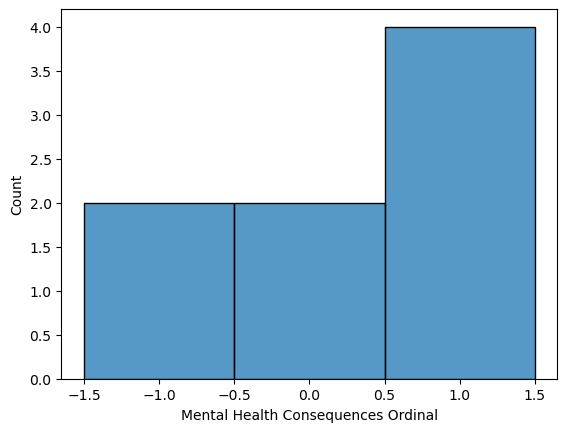

In [40]:
#histograms of ordinal mental health consequences for Non-Binary folks
sns.histplot(gender_consequence[gender_consequence.Gender=='NB'],x = 'Mental Health Consequences Ordinal', discrete = True)


Histogram of the mean responses from male employees. 

<AxesSubplot:xlabel='Mental Health Consequences Ordinal', ylabel='Count'>

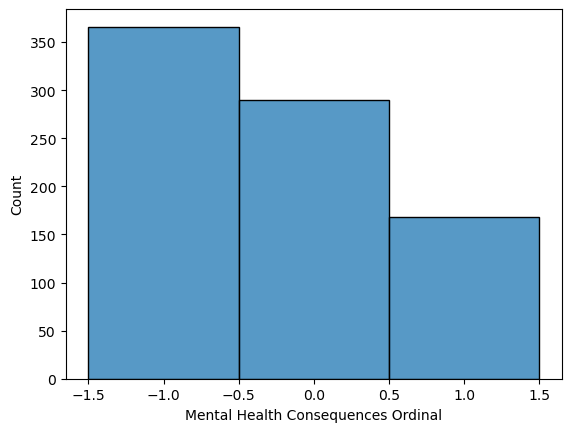

In [41]:
#histograms of ordinal mental health consequences for Males
sns.histplot(gender_consequence[gender_consequence.Gender=='M'],x = 'Mental Health Consequences Ordinal', discrete = True)

The above 3 histograms give an idea of how each gender identity feels about the consequences of discussing mental health with their employer. F shows a somewhat normal distribution with responses being emphasized with "Maybe" responses, while NB is left skewed and M is right skewed. We can see that males are more confident in believing that they are able to confide their mental health issues with employers as opposed to females and non-binary people.

We wanted to test if this difference of values is statistically significant or due to random chance. Thus, we perform a hypothesis test. Our null and alternative hypotheses are as follows:

Null: Males vs. Non-Males feel the same about whether their employers will fault them for discussing mental health. Any difference is due to random chance

Alternative Hypothesis: Non-Males are more likely to believe that their employers will fault them for discussing mental health.

In [42]:
# Digging deeper to do hypothesis test of whether the observed difference is statistically significant:
gender_copy = gender_consequence.copy() #creating a copy of the gender_consequence df
results = [] # empty array to store results
#1000 iterations of the test
for _ in range(1000):
    gender_copy['Gender'] = np.random.permutation(gender_copy['Gender']) # shuffle the gender column at random
    cur_m_mean = gender_copy[gender_copy.Gender=='M']['Mental Health Consequences Ordinal'].mean() # compute male mean
    cur_nonm_mean = gender_copy[gender_copy.Gender!='M']['Mental Health Consequences Ordinal'].mean() #compute non-male mean
    test_diff = cur_nonm_mean-cur_m_mean #compute diff in non-male and male mean
    results += [test_diff] # append the current test statistic to the results array
p_val = (np.array(results)>=obs).mean() #compute the p-val for our test

In [43]:
p_val

0.002

Our hypothesis test shows that our observed difference in means is statistically significant difference at the 1% significance level. That is, we reject our null hypothesis that males and non-males feel the same about the possibility of facing consequences for discussing mental health. 

This section gives us clarification with our research question and seems to possible validate our hypothesis, that the different genders do in fact have differences in how comfortable disussing mental health issues without the fear of facing negative consequences. Through data analysis, we can see that there is a difference between the responses given by men, women, and non-binary employees. It seems that men are more comfortable with possibly discussing mental health issues with their employees without the fear of facing negative consequences, which raises the question of why, and if this has anything to do with the possible differences in experience between men and women in the tech industry. 

# Comparing number of those who sought mental health treatment based on gender

This next section will looks at the comparison between survey participant’s responses that answered the question “have you sought treatment for a mental health condition?” 

In the tech_data dataframe the column 'Sought Treatment' records each participant's response with a specifc ordinal number: 'Yes' is 1, 'No' is 0.

We will analyze the data by first counting the number of the participants' responses and differentiating these repsonses depending on the gender of the participant. The second way we will analyze this data further by getting the proportion of each gender and their responses due to ther higher number of male responses(637) with female responses(163) and nonbinary responses(8).

This data does not contain any outliers since it was a yes or no question in the survey.

In [44]:
sought_treatment = tech_data[['Gender', 'Sought Treatment']]
sought_treatment = sought_treatment.dropna(subset = ['Sought Treatment'])
sought_treatment = sought_treatment.reset_index(drop = True)

In [45]:
sought_treatment

,Gender,Sought Treatment
0,F,1
1,M,0
2,M,1
3,M,0
4,M,0
...,...,...
1018,M,1
1019,M,1
1020,M,1
1021,M,1


## Figure 1

This figure counts the number of yes or no responses on whether or not they sought treatment depending on gender.

<AxesSubplot:xlabel='Sought Treatment', ylabel='count'>

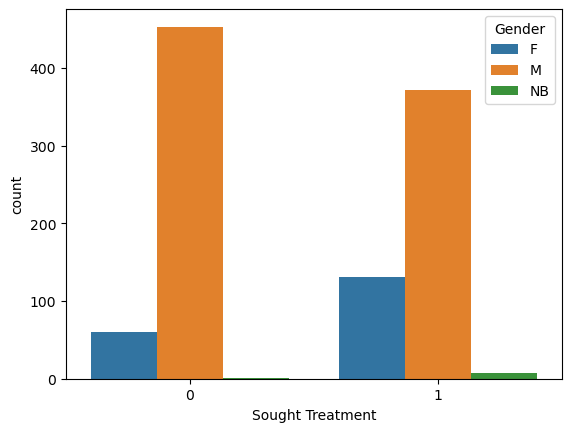

In [46]:
sns.countplot(data = sought_treatment, x = "Sought Treatment", hue = "Gender")

In [47]:
treatment = pd.DataFrame({'Gender':['F','F','M','M', 'NB', 'NB'],
                       'Sought Treatment':['1', '0', '1', '0', '1', '0']})
treatment = treatment.sort_values('Gender', ascending=True)

treatment = tech_data.groupby('Gender')['Sought Treatment'].value_counts().reset_index(name='prop')
femalesum=treatment.groupby('Gender')['prop'].sum()['F']
malesum=treatment.groupby('Gender')['prop'].sum()['M']
nbsum= treatment.groupby('Gender')['prop'].sum()['NB']

treatment.loc[0, 'prop'] = treatment.loc[0, 'prop'] / femalesum
treatment.loc[1, 'prop'] = treatment.loc[1, 'prop'] / femalesum
treatment.loc[2, 'prop'] = treatment.loc[2, 'prop'] / malesum
treatment.loc[3, 'prop'] = treatment.loc[3, 'prop'] / malesum
treatment.loc[4, 'prop'] = treatment.loc[2, 'prop'] / nbsum
treatment.loc[5, 'prop'] = treatment.loc[3, 'prop'] / nbsum


In [48]:
treatment

,Gender,Sought Treatment,prop
0,F,1,0.685864
1,F,0,0.314136
2,M,0,0.549757
3,M,1,0.450243
4,NB,1,0.068720
5,NB,0,0.056280


## Figure 2

This figure also comapres the yes or no responses to the same survey question but takes into account the proportion of genders.

<AxesSubplot:xlabel='Sought Treatment', ylabel='prop'>

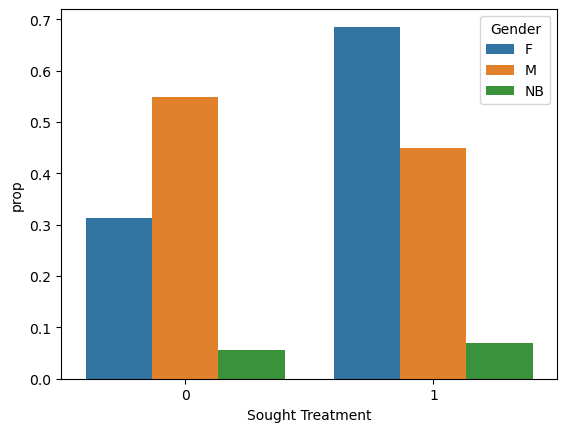

In [49]:
plot_proportion = sns.barplot(data=treatment, x=treatment['Sought Treatment'], y=treatment['prop'], hue=treatment['Gender'])

plot_proportion

In figure 1, we created a count box that demonstrated how men are more likely to seek treatment but this graph does not take into account the proportions.Since it does not take into account the proportions the number of men who sought treatment is much higher compared to the female and nonbinary people. 

Taking into consideration of the proportions for genders, figure 2 demonstrates how female and nonbinary  identifying people often seek more mental health treatment despite the number of female/nonbinary employees being so low compared to the male employee. 